In [1]:
!pwd
!which python

/home/wwc/bem_git/bem/examples/3DTrap
/home/wwc/anaconda3/envs/ele36/bin/python


In [1]:
import sys
import logging, os
from importlib import reload
import numpy as np
# To import pyface.py is just for setting "Qt" sip API version to 2 before matplotlib sets it to default v1 
# that is incompatible with "pyside" in package "mayavi". wwc
import pyface.qt    
import matplotlib.pyplot as plt
from multiprocessing import Pool    # parallel computation.

sys.path.append('../../')   # add path of package "bem" to search list. wwc
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list. wwc

# electrode is an another package in nist-ionstorage github. wwc
from electrode import System, GridElectrode

In [2]:
prefix = "hucul-wwc_180813_0d1-0d1-5"
suffix = ""

In [3]:
# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 RF1 RF2".split():    #  DC2 DC3 DC4 DC5 RF
    # r = Result.from_vtk(prefix, name), r is a Result instance.
    # GridElectrode has both 1.from_result() to import Result instance, and 2.from_vtk() to import vtk directly.
    # 1.r after from_result(): e ~ obj = cls(origin=origin, spacing=spacing, data=pot). 
    # 2.A vtk file after from_vtk(): obj = cls(origin=origin, spacing=spacing, data=pot). 
    # So after using from_vtk() we jump over r and get to e.
    e = GridElectrode.from_vtk("%s%s_"%(prefix,suffix)+name+".vtk",maxderiv=4)    # from_vtk() is classmethod()
    e.name = name
    s.append(e)    # class System(list), System inherits list method "append" wwc
# For why instance s is subscriptable (can use []), this relates to "__getitem__() method" in System() class.  wwc
print(s["RF1"],s["RF1"].rf)
print(e,e.rf)

<electrode.electrode.GridElectrode object at 0x7f86d93c7db0> 0.0
<electrode.electrode.GridElectrode object at 0x7f86d93c7f68> 0.0


In [8]:
import scipy.constants as ct
l = 200e-6 # length scale
u = 168 # peak rf voltage
o = 34.1e6*2*np.pi # rf frequency
m = 174*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
rf_scale = s.rf_scale(m,q,l,o) # np.sqrt(q/m)/(2*l*o). Square root of RF pseudo-potential coefficient.

V0 = u
V1,V2 = 5,5
DCvol = {"DC1":V1,"DC2":V2,"DC3":0,"DC4":V2,"DC5":V1,
         "DC6":V1,"DC7":V2,"DC8":0,"DC9":V2,"DC10":V1}
for edc in DCvol:
    s[edc].dc = DCvol[edc]
    print(edc,s[edc].dc,"V")
# Pay attention to s.rf_scale(m,q,l,o) pesudo potential coefficient! See blakestad2010 Eq.(5.2).  wwc
s["RF1"].rf = rf_scale*V0    # s["RF"] == e, create attribute e.rf  wwc
s["RF2"].rf = rf_scale*V0
# s["RF"].rf = u*np.sqrt(q/m)/(2*l*o)
# s["RF1"].dc = 0
# s["RF2"].dc = 0
print("RF1",s["RF1"].rf,"V")
print("RF2",s["RF2"].rf,"V")

xi = (0., 0., 0.)
x0 = s.minimum(xi)
#x0 = np.array([ 0.22595712, -0.03207475, -0.03303389])+10e-9/l*np.array([0.00128987, 0.96771493, 0.25204395])
#np.array([-1.32449730e-04, -2.52043992e-01,  9.67715768e-01])#
print("\nx0",x0)
print("minimum offset: %s\n"%(x0-xi))
# analyze_static(x, axis=(0, 1, 2), m=ct.atomic_mass, q=ct.elementary_charge, l=100e-6, o=2*np.pi*1e6, ions=1, log=None):
for line in s.analyze_static(np.array(xi), m=m, q=q, l=l, o=o):      # u=50., # u is V rf peak voltage, but it causes error.
    print(line)

DC1 5 V
DC2 5 V
DC3 0 V
DC4 5 V
DC5 5 V
DC6 5 V
DC7 5 V
DC8 0 V
DC9 5 V
DC10 5 V
RF1 1.4597250762771379 V
RF2 1.4597250762771379 V

x0 [ 0.22595712 -0.03207475 -0.03303389]
minimum offset: [ 0.22595712 -0.03207475 -0.03303389]

parameters:
 f=34.1 MHz, m=174 amu, q=1 qe, l=200 µm, scale=0.00869 V'/V_SI
coordinates:
 analyze point: [0. 0. 0.]
               ([0. 0. 0.] µm)
 minimum is at offset: [ 0.22595712 -0.03207475 -0.03303389]
                      ([45.1914241  -6.41495054 -6.60677724] µm)
potential:
 dc electrical: 0.899 eV
 rf pseudo: 0.00268 eV
 saddle offset: [0.22914314 0.28692571 0.71947052]
               ([ 45.82862806  57.38514169 143.89410308] µm)
 saddle height: 0.24 eV
force:
 dc electrical: [-0.36400425 -0.05947169 -0.02039369] eV/l
               ([-1820.02125    -297.3584375  -101.9684375] eV/m)
 rf pseudo: [5.71111867e-05 8.15600773e-02 8.45036210e-02] eV/l
           ([2.85555934e-01 4.07800387e+02 4.22518105e+02] eV/m)
 total: [-0.36394714  0.02208839  0.0641099

In [6]:
pp_min = np.array([-2.19863368e-05, -3.16736280e-02, -3.30070797e-02])
tot_min = np.array([ 0.22595712, -0.03207475, -0.03303389])
pp_min-tot_min

array([-2.25979106e-01,  4.01122000e-04,  2.68103000e-05])

In [7]:
import electrode.adjust
reload(electrode.adjust)

<module 'electrode.adjust' from '../../../electrode/electrode/adjust.py'>

In [19]:
# Nulling stray charge.
from electrode.adjust import Adjust

V0 = 0
V1,V2 = 5,5
dc_volts = {"DC1":V1,"DC2":V2,"DC3":0,"DC4":V2,"DC5":V1,
         "DC6":V1,"DC7":V2,"DC8":0,"DC9":V2,"DC10":V1,
        "RF1":0,"RF2":0}    # initial <electrode>.dc values
# Force or new minimum only offers 3 contraints, while we have 12 electrodes.
# E_config specifies 3 sets of electrodes that will change their voltages. Same set has same change. 
# Pay attention to the trap symmetry that some combinations can have evident effects with small changes.
E_config = [["RF1","RF2"],["DC2","DC4"],["DC3"]]

ns = Adjust(s)
ns.set_volts(dc_volts,save=True)
xm_ini, axs = ns.set_move_init(E_config=E_config)
# print(ns.volts)

# check if we set expected dc volts.
for edc in s:
    print(edc.name,edc.dc,"V")
# The basis used in following adjustments. They are fixed.
for ith in axs:
    print(*ith)

DC1 5 V
DC2 5 V
DC3 0 V
DC4 5 V
DC5 5 V
DC6 5 V
DC7 5 V
DC8 0 V
DC9 5 V
DC10 5 V
RF1 0 V
RF2 0 V
axial [ 9.99999159e-01 -1.28160763e-03 -1.96929555e-04]
radial1 [0.00128987 0.96771493 0.25204395]
radial2 [-1.32449779e-04 -2.52043992e-01  9.67715768e-01]


In [9]:
factor = np.sqrt(q/m)/(2*np.pi*l)
print("Start: min: {}\nfreq: {} MHz\nconfig: {}\n".format(ns.xms[0],ns.curves[0],ns.E_config))

Nmove = 5
dis = 10e-9
ax = 1
for i in range(Nmove):
    tmp = ns.propose_move(axis=ax, l=l, dis=dis, method="position")    # move dis=10 nm
#     print("DC3",s["DC3"].dc)
    print("#%s move:"%(i+1))
    for ele, dV in zip(ns.E_config,tmp[0]):
        print(ele, dV, "V")
    print("New minimum: {} l, offset: {} nm".format(tmp[1][0], tmp[1][1]*l/1e-9))
    print("Expected displacement: {}".format(dis/1e-9*axs[ax][1]))
    print("Frequencies change: {} MHz".format(tmp[2]*factor/1e6))
    print("Eigen-axes change: {}".format(tmp[3]))
    ns.next_step(accept=True)
    print()
    
print("\n{}\n{}\n{}\n{}\n".format(ns.xms,ns.curves,ns.volts,ns.E_config))
              
#print(ns.xms,ns.curves,ns.basis,ns.E_config)
# print("tmp")
# for item in tmp:
#     print(item)
# print(ns._propose)

Start: min: [ 0.22595712 -0.03207475 -0.03303389]
freq: [1.63890068 1.00853667 2.53212987] MHz
config: [['RF1', 'RF2'], ['DC2', 'DC4'], ['DC3']]

#1 move:
['RF1', 'RF2'] -0.0005377871234549548 V
['DC2', 'DC4'] -0.0021864157284079617 V
['DC3'] 0.000639628652696144 V
New minimum: [ 0.22595719 -0.03202634 -0.03302128] l, offset: [0.01294774 9.68170726 2.52222913] nm
Expected displacement: [0.01289867 9.67714929 2.5204395 ]
Frequencies change: [-1.00782583e-04  2.12776463e-05  6.24291601e-05] MHz
Eigen-axes change: [[-2.64318600e-09 -1.78549057e-06 -1.78590095e-06]
 [ 2.12840744e-06 -9.51344292e-05  3.64972585e-04]
 [ 7.90912928e-07 -3.64974338e-04 -9.51318722e-05]]

#2 move:
['RF1', 'RF2'] -0.0005381643055523864 V
['DC2', 'DC4'] -0.002185637303500934 V
['DC3'] 0.0006396297141713519 V
New minimum: [ 0.22595725 -0.03197794 -0.03300866] l, offset: [0.01294771 9.68167599 2.5222284 ] nm
Expected displacement: [0.01289867 9.67714929 2.5204395 ]
Frequencies change: [-2.01538741e-04  4.23644098e-

In [10]:
# Nulling stray charge.
from scipy.linalg import solve as scipy_solve

reset = True
if reset:
    # Reset .dc voltages
    for edc in DCvol:
        s[edc].dc = DCvol[edc]
        print(edc,s[edc].dc,"V")
    s["RF1"].dc, s["RF2"].dc = 0.,0.
    
xi = (0.,0.,0.)
#xc = s.minimum(xi)
xc = np.array([ 0.22595712, -0.03207475, -0.03303389])
asdf = s.potential(xc,2)[0]    # Do this before s.modes(xc), or s.modes(xc) can be different even .dc is reset.
evalue, evector = s.modes(xc)
print("Eigenvalues:",evalue)
print("Eigenvectors:\n",evector)
el_radial, ev_radial = evalue[[0,2]],evector.T[[0,2]]    # [1] is axial axis
print("Radial eigenvectors:\n",ev_radial)

Nele = 3
Id = np.eye(Nele)
Zero = np.zeros(Nele)
DCid = {"DC1":Zero,"DC2":Id[1],"DC3":Id[2],"DC4":Id[1],"DC5":Zero,
         "DC6":Zero,"DC7":Zero,"DC8":Zero,"DC9":Zero,"DC10":Zero,
        "RF1":Id[0],"RF2":Id[0]}
E_config = [["RF1","RF2"],["DC2","DC4"],["DC3"]]

DC1 5 V
DC2 5 V
DC3 0 V
DC4 5 V
DC5 5 V
DC6 5 V
DC7 5 V
DC8 0 V
DC9 5 V
DC10 5 V
Eigenvalues: [1.00853667 1.63890068 2.53212987]
Eigenvectors:
 [[ 1.28986687e-03  9.99999159e-01 -1.32449730e-04]
 [ 9.67714929e-01 -1.28160766e-03 -2.52043992e-01]
 [ 2.52043950e-01 -1.96929613e-04  9.67715768e-01]]
Radial eigenvectors:
 [[ 1.28986687e-03  9.67714929e-01  2.52043950e-01]
 [-1.32449730e-04 -2.52043992e-01  9.67715768e-01]]


In [11]:
# xn = np.array([0.,0.,0.])
# Fp = s.potential(xn,1)[0]    # xn is the current ion position    # eV/ls
# Fpn = np.linalg.norm(Fp)
dis = 10e-9
E_scale = el_radial*dis/l
print("Force F at minimum with {:.2f}nm displacement: {} (eV/m)".format(dis/1e-9, E_scale/l))

# coef = np.zeros((Nele,3))
# for i in range(3):
#     for ele in DCid:
#         coef[:,i] += s[ele].potential(xc,derivative=1)[0].T*DCid[ele][i] 
# # print("Coef:\n",coef,"\n")
# deltaV = [scipy_solve(coef,Ev*ev) for Ev,ev in zip(E_scale,ev_radial)]
# print("Delta V:\n",deltaV,"\n")


Nele = len(E_config)    # If you only confine force, Nele = 3
Id,Zero = np.eye(Nele),np.zeros(Nele)
coef = np.zeros((3,Nele))
xm_old = xc#self.xms[-1]	# minimum of last move
for ith in range(Nele):
    for ele in E_config[ith]:
        coef[:,ith] += s[ele].potential(xm_old,derivative=1)[0].T
# deltaV = scipy_solve(coef,E_scale*self.basis)
deltaV = [scipy_solve(coef,Ev*ev) for Ev,ev in zip(E_scale,ev_radial)]
print("Delta V:\n",deltaV,"\n")

# for ev,dV in zip(ev_radial,deltaV):
#     print("Eigen-axis:",ev)
ith = 0    # ith eigen-axis
print("Solution along eigen-axis:",ev_radial[ith])
for ele,dVi in zip(ele_change,deltaV[ith]):
    print(ele,dVi)
    for elei in ele:
        s[elei].dc += dVi
            
print()
for edc in DCid:
    print(edc,s[edc].dc,"V")  # change .dc scale voltages
print("RF1.rf",s["RF1"].rf,"V")
print("RF2.rf",s["RF2"].rf,"V")

print()
xnew = s.minimum((0.1,0.,0.))
print((xnew-xc)*l/1e-6)
for line in s.analyze_static(x0, m=m, q=q, l=l, o=o):
    print(line)

Force F at minimum with 10.00nm displacement: [0.25213417 0.63303247] (eV/m)
Delta V:
 [array([ 0.00056078,  0.00219607, -0.00064219]), array([-0.00025318,  0.00369944, -0.00053712])] 

Solution along eigen-axis: [0.00128987 0.96771493 0.25204395]


NameError: name 'ele_change' is not defined

In [ ]:
# Compute Mathieu parameters a, q. According to the eigen-axes of the RF Hessian, and transform DC Hessian.
dc2 = s.electrical_potential(x0, "dc", 2, expand=True)[0]
rf2 = s.electrical_potential(x0, "rf", 2, expand=True)[0]
print("DC Hessian:\n",dc2)
print("RF Hessian:\n",rf2)
dcei = np.linalg.eigh(dc2)
rfei = np.linalg.eigh(rf2)
# print(dcei)
# print(rfei)
dc2n = rfei[1].T@dc2@rfei[1]    # matrix multiplication, rfei[1] is change basis matrix.
print("Transform DC:\n",dc2n)
a = 16*rf_scale**2*dc2n.diagonal()
q = 16*rf_scale**2*rfei[0]
print("Transformed a:",a)
print("Eigen q:",q)
#print("\n",a+q**2/2)

In [ ]:
# Both RF and DC are eigen-axes Hessian, without 
print("DC eigenvectors:\n",dcei[1])
print("RF eigenvectors:\n",rfei[1])
a = 16*rf_scale**2*np.linalg.eigh(dc2)[0]
q = 16*rf_scale**2*np.linalg.eigh(rf2)[0]
print("Eigen a:",a)
print("Eigen q:",q)

In [ ]:
# # To understand the data structure of GridElectrode.data.  wwc
# print(e.origin, e.spacing)
# print(len(e.data),type(e.data))  # [pot_array,field_array,2nd_pot_array,3rd_pot_array], 0~3,4th derivative order.
# print(type(e.data[0]),type(e.data[1]))  # All list elements are ndarray.
# print(e.data[0].shape,e.data[1].shape)    # (nx,ny,nz,components)
# print(e.data[0])    # potential
# # [[[[p(x0,y0,z0)],
# #    [p(x0,y0,z1)],
# #    [p(x0,y0,z2)]],
# #    
# #   [[p(x0,y1,z0)],
# #    [p(x0,y1,z1)],
# #    [p(x0,y1,z2)]],     
# #
# #   ]]

In [ ]:
# This is from electrode turtorial.ipynb  wwc
# import scipy.constants as ct
# l = 30e-6 # µm length scale
# u = 20. # V rf peak voltage
# m = 25*ct.atomic_mass # ion mass
# q = 1*ct.elementary_charge # ion charge
# o = 2*np.pi*100e6 # rf frequency in rad/s
# s["RF"].rf = u*np.sqrt(q/m)/(2*l*o)
# print(s["RF"])

# x0 = s.minimum((0, 0, 1.), axis=(1, 2))

# for line in s.analyze_static(x0, axis=(1,0), m=m, q=q, l=l, o=o):
#     print(line)

In [ ]:
# Test np.linalg.eigh.
# mat = np.array([[3,0,1],[0,2,0],[1,0,3]])
# print(mat)
# np.linalg.eigh(mat)

In [14]:
l = 200e-6 # length scale
u = 168 # peak rf voltage
o = 34.1e6*2*np.pi # rf frequency
m = 174*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
rf_scale = s.rf_scale(m,q,l,o) # np.sqrt(q/m)/(2*l*o). Square root of RF pseudo-potential coefficient.

V0 = u
V1,V2 = 0,0
DCvol = {"DC1":V1,"DC2":V2,"DC3":0,"DC4":V2,"DC5":V1,
         "DC6":V1,"DC7":V2,"DC8":0,"DC9":V2,"DC10":V1}
for edc in DCvol:
    s[edc].dc = DCvol[edc]
    print(edc,s[edc].dc,"V")
# Pay attention to s.rf_scale(m,q,l,o) pesudo potential coefficient! See blakestad2010 Eq.(5.2).  wwc
s["RF1"].rf = 1#rf_scale*V0    # s["RF"] == e, create attribute e.rf  wwc
s["RF2"].rf = 1#rf_scale*V0
# s["RF"].rf = u*np.sqrt(q/m)/(2*l*o)
# s["RF1"].dc = 0
# s["RF2"].dc = 0
print("RF1",s["RF1"].rf,"V")
print("RF2",s["RF2"].rf,"V")

DC1 0 V
DC2 0 V
DC3 0 V
DC4 0 V
DC5 0 V
DC6 0 V
DC7 0 V
DC8 0 V
DC9 0 V
DC10 0 V
RF1 1 V
RF2 1 V


In [10]:
# x is single point coord. x will be round to neatest points so x never go beyond boundary.
xi = (0., 0., 0.)
x0 = s.minimum(xi)
print("\nx0",x0)
print("minimum offset: %s\n"%(x0-xi))
#x0 = np.array([0.0,1.0,1.0])
print("potential at x0:",s.potential(x=x0,derivative=0)[0])
print("min DC1 potential:",np.amin(s["DC1"].data[0]))
print()

print(s.potential(x0, 2)[0])
eigen = np.linalg.eigh(s.potential(x0, 2)[0])
print(eigen)
s.modes(x0)


x0 [-2.19863368e-05 -3.16736280e-02 -3.30070797e-02]
minimum offset: [-2.19863368e-05 -3.16736280e-02 -3.30070797e-02]

potential at x0: 1.2937659103055288e-09
min DC1 potential: -0.000267127

[[ 1.56562518e-06 -2.43067646e-04 -1.10105224e-03]
 [-2.43067646e-04  1.20724505e+00 -8.89929909e-04]
 [-1.10105224e-03 -8.89929909e-04  1.20724741e+00]]
(array([5.12159399e-07, 1.20635705e+00, 1.20813647e+00]), array([[ 9.99999564e-01, -7.87388644e-04, -5.02900046e-04],
       [ 2.02013189e-04,  7.07764743e-01, -7.06448177e-01],
       [ 9.12184194e-04,  7.06447768e-01,  7.07764593e-01]]))


(array([5.12159399e-07, 1.20635705e+00, 1.20813647e+00]),
 array([[ 9.99999564e-01, -7.87388644e-04, -5.02900046e-04],
        [ 2.02013189e-04,  7.07764743e-01, -7.06448177e-01],
        [ 9.12184194e-04,  7.06447768e-01,  7.07764593e-01]]))

In [11]:
# Create grid of x,y,z that fit into the original one.
start = np.array([-1,-1,-1])    # Lx, Ly, Lz
end = np.array([1,1,1])
nextra = 1
#print(1,start,end)
ngd_s = np.floor((start-s["RF1"].origin)/s["RF1"].spacing).astype(int)
ngd_e = np.floor((end-s["RF1"].origin)/s["RF1"].spacing).astype(int)
#print(2,ngd_s,ngd_e)
start = np.round(ngd_s*s["RF1"].spacing+s["RF1"].origin,5)    # round 5 digits.  wwc
end = np.round(ngd_e*s["RF1"].spacing+s["RF1"].origin,5)
#print(3,start,end)
ngd = np.floor((end-start)/s["RF1"].spacing).astype(int)
# xyz is the potential coords
xyz = [np.linspace(st,en,(ng+1)*nextra)
       for st,en,ng in zip(start,end,ngd)]
# mgrid slices to take out a part of xyz grid
slc = [slice(st,en,1j*(ng+1)*nextra) 
       for st,en,ng in zip(start,end,ngd)]
print(slc)

# Find and print minimum/saddle offset and height. 
xi = (0., 0., 0.)
x0 = s.minimum(xi)
#x0 = np.array([0.25,-0.02,-0.02])
print("\nminimum:",x0)
print("minimum offset: %s"%(x0-xi))
xs,xsp = s.saddle(x0+1e-1*x0[2])    # xs: saddle point, xsp: saddle potential  wwc
p_dc = s.electrical_potential(x0,"dc",0)[0]
p_rf = s.pseudo_potential(x0,0)[0]
print("\nsaddle:",xs)
print("saddle offset: %s"%(xs-x0))
print("saddle height:",xsp-(p_dc+p_rf))

[slice(-1.025, 0.975, 41j), slice(-1.025, 0.975, 41j), slice(-1.025, 0.975, 41j)]

minimum: [-2.19863368e-05 -3.16736280e-02 -3.30070797e-02]
minimum offset: [-2.19863368e-05 -3.16736280e-02 -3.30070797e-02]

saddle: [-0.14156555 -0.03170082 -0.03315377]
saddle offset: [-1.41543559e-01 -2.71881418e-05 -1.46690926e-04]
saddle height: [4.99445522e-09]


20 -0.02499999999999991
mgrid shape: (3, 41, 41) 

yz plane, potential shape: (41, 41)
max/min potential: 5.66252208048424 4.140290110750247e-06


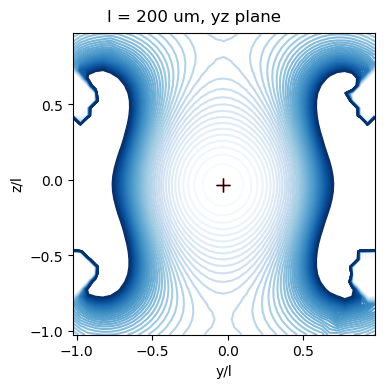

In [19]:
# Create 2D yz mgrids.
xpl = 0    # xpl is the cross-section plane coordinate. Here it's yz plane.
xpln = np.rint((xpl-start[0])/s["RF1"].spacing[0]).astype(int)
print(xpln,xyz[0][xpln])    # xyz[0][xpln] is the nearest grid point near xpl.
xyzg = np.mgrid[slc][:,xpln]    # yz plane
#yzg = np.mgrid[[slc[1],slc[2]]]
print("mgrid shape:",xyzg.shape,"\n")

# Sum up total potentials on yz plane at xpl.
pot = []
for y in xyz[1]:
    # s.potential(x=(xpl,y,z),derivative=0) returns a shape (1,) array. array[pot(xpl,y,z)]. So add a [0].  wwc
    potx = np.array([s.potential(x=(xpl,y,z),derivative=0)[0] for z in xyz[2] ])          
    pot.append(potx)
pot = np.array(pot)
maxp, minp = np.amax(pot),np.amin(pot)
print("yz plane, potential shape:",pot.shape)
print("max/min potential:",maxp,minp)

# Plot the potential, as well as minimum and saddle points.
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyzg[1], xyzg[2], pot, levels=np.linspace(minp, maxp/10, 50), cmap=plt.cm.Blues)
ax.plot(x0[1],x0[2],'r+',markersize=10)
ax.plot(xs[1],xs[2],'k+',markersize=10)

# start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-1,1, 0.5))
ax.set_xlabel("y/l",fontsize=10)
ax.set_ylabel("z/l",fontsize=10)
ax.text(-0.8,1.05,"l = %d um, yz plane"%(l/1e-6),fontsize=12)
fig.set_size_inches(4, 4)
fig.set_dpi(100)

30 0.4750000000000001
mgrid shape: (3, 41, 41) 

(41, 41)
xy plane, potential shape: (41, 41)
max/min potential: 5.042058979749998 -0.0036423280125000277


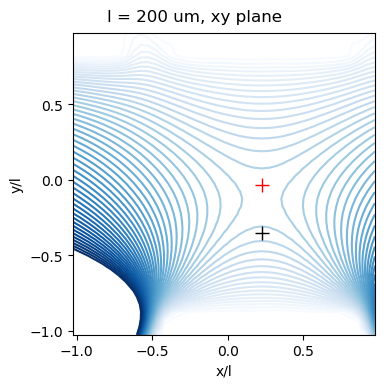

In [28]:
# Create 2D xy mgrids.
zpl = 0.5    # zpl is the cross-section plane coordinate. Here it's xy plane.
zpln = np.rint((zpl-start[2])/s["RF1"].spacing[2]).astype(int)
print(zpln,xyz[2][zpln])    # xyz[0][xpln] is the nearest grid point near xpl.
xyzg = np.mgrid[slc][:,:,:,zpln]    # xy plane
#yzg = np.mgrid[[slc[1],slc[2]]]
print("mgrid shape:",xyzg.shape,"\n")

# Sum up total potentials on xy plane at zpl.
pot = []
for x_ in xyz[0]:
    # s.potential(x=(xpl,y,z),derivative=0) returns a shape (1,) array. array[pot(xpl,y,z)]. So add a [0].  wwc
    potz = np.array([s.potential(x=(x_,y_,zpl),derivative=0)[0] for y_ in xyz[1] ])          
    pot.append(potz)
pot = np.array(pot)
print(pot.shape)
maxp, minp = np.amax(pot),np.amin(pot)
print("xy plane, potential shape:",pot.shape)
print("max/min potential:",maxp,minp)

# Plot the potential, as well as minimum and saddle points.
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyzg[0], xyzg[1], pot, levels=np.linspace(minp, maxp/2, 50), cmap=plt.cm.Blues)
ax.plot(x0[0],x0[1],'r+',markersize=10)
ax.plot(xs[0],xs[1],'k+',markersize=10)

ax.yaxis.set_ticks(np.arange(-1,1, 0.5))
ax.set_xlabel("x/l",fontsize=10)
ax.set_ylabel("y/l",fontsize=10)
ax.text(-0.8,1.05,"l = %d um, xy plane"%(l/1e-6),fontsize=12)
fig.set_size_inches(4, 4)
fig.set_dpi(100)

In [ ]:
#ar = [np.arange(st,en,spn) for st,en,spn in zip(start,end,s["RF"].spacing/nextra)]
#print(ar)
# ngd = np.floor((end-start)/s["RF"].spacing).astype(int)*nextra

# pot = np.array([s.potential(x=(xpl,ar[1],ar[2]),derivative=0)])

In [ ]:
s["DC1"].data[0].shape
s1 = s["DC1"].data[0].reshape((62,62,62))
s1.shape

In [ ]:
print(s["RF"].origin)
print(s["RF"].spacing)

start = np.array([-0.5,0.5,0.5])
end = np.array([0.5,2.0,1.5])
print(1,start,end)
ngd_s = np.floor((start-s["RF"].origin)/s["RF"].spacing).astype(int)
ngd_e = np.floor((end-s["RF"].origin)/s["RF"].spacing).astype(int)
print(2,ngd_s,ngd_e)
start = np.round(ngd_s*s["RF"].spacing+s["RF"].origin,8)    # round 8 digits.  wwc
end = np.round(ngd_e*s["RF"].spacing+s["RF"].origin,8)
print(3,start,end)

ngd = np.floor((end-start)/s["RF"].spacing).astype(int)
slc = [slice(st,en,1j*(ng+1)) 
       for st,en,ng in zip(start,end,ngd)]
print(slc)
#np.mgrid[slc]

In [ ]:
n = 50
xyz = np.mgrid[-d:d:1j*n, -d:d:1j*n, h:h+1]
fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect="equal"))
pot = shaped(s.potential)(xyz)
v = np.arange(-15, 3)
x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
ax[0].contour(x, y, np.log2(p), v, cmap=plt.cm.hot)

(xs1, ps1), (xs0, ps0) = s.saddle(x0+1e-2), s.saddle([0, 0, .8])
print("main saddle:", xs0, ps0)
xyz = np.mgrid[-d:d:1j*n, 0:1, .7*h:3*h:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
ax[1].contour(x, z, np.log2(p), v, cmap=plt.cm.hot)
ax[1].contour(x, z, np.log2(p), np.log2((ps1, ps0)), color="black")